<a href="https://colab.research.google.com/github/maryj31/simple_genai_project/blob/main/Covolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import wandb

In [ ]:
# load and prepare the dataset

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [ ]:
data_path = os.listdir(path=path)
data_path = os.path.join(path, data_path[1])


# download the data into pytorch image folder
#set up transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([200,200]),
    transforms.RandomHorizontalFlip(p=0.4)
])

# load the dataset
data = datasets.ImageFolder(root=data_path, transform=transform)

# split the dataset into train and test set
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(dataset=data, lengths=[train_size,test_size])

# set up data loader
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

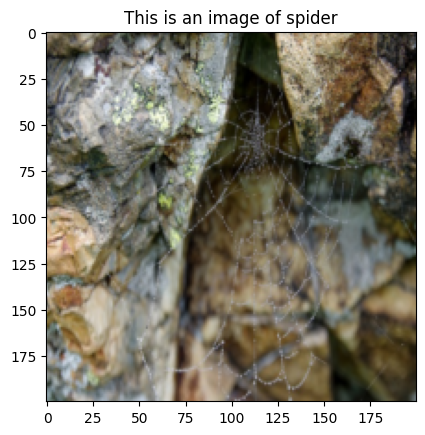

In [ ]:
# visualize the data
animal_list = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
               "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
               "mucca": "cow", "pecora": "sheep","ragno": "spider", "scoiattolo": "squirrel"}
animal_list = list(animal_list.values())

def display_image(image_index):
  plt.imshow(np.transpose(train_data[image_index][0], (1,2,0)))
  plt.title(f'This is an image of {animal_list[train_data[image_index][1]]}')

display_image(8118)

In [ ]:
train_data[0][0].shape[]

torch.Size([3, 200, 200])

In [ ]:
64 * 50 * 50

160000

In [ ]:
# setup the computational graph


class Animal_NN(nn.Module):

  def __init__(self) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # 32 x 200 x 200
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64 X 200 x 200
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # after one round of pooling 64 x 100 x 100
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=64*50*50, out_features=1000)
    self.fc2 = nn.Linear(in_features=1000, out_features=500)
    self.out = nn.Linear(in_features=500, out_features=len(animal_list))
    self.dropout = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    result = self.pool(self.relu(self.conv1(X)))
    result = self.pool(self.relu(self.conv2(result))) # 64 * 50 * 50
    result = self.flatten(result)
    result = self.dropout(self.relu(self.fc1(result)))
    result = self.dropout(self.relu(self.fc2(result)))
    result = self.out(result)

    return result

In [ ]:
# init the model and define the hyperparameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Animal_NN().to(device)
LEARNING_RATE = 1e-4
optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
EPOCHS = 5

In [ ]:
run = wandb.init(
    project = "Animal Classification Project",
    config = {
        'device': device,
        'lr': LEARNING_RATE,
        'optimizer': 'AdamW',
        'weight decay value': 0.01,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'data_path': path
    }
)

In [ ]:
# setup the training and validation loop

for epoch in range(EPOCHS):
  model.train()
  train_epoch_loss = []
  test_epoch_loss = []
  train_batch = tqdm(train_loader, desc= f'Training Epoch: {epoch+1}/{EPOCHS}')
  for image, label in train_batch:
    image, label = image.to(device), label.to(device)
    train_preds = model(image)
    loss = criterion(train_preds, label)

    # back prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_epoch_loss.append(loss.item())

    train_batch.set_postfix(loss=loss.item())
  # get the final loss for the epoch
  final_train_epoch_loss = sum(train_epoch_loss)/len(train_epoch_loss)

  # compute the validation
  model.eval()
  with torch.no_grad():
    test_batch = tqdm(test_loader, desc = f'Testing epoch: {epoch + 1}')
    for test_image, test_label in test_batch:
      test_image, test_label = test_image.to(device), test_label.to(device)
      test_pred = model(test_image)
      test_loss = criterion(test_pred, test_label)
      test_epoch_loss.append(test_loss.item())

  final_test_epoch_loss = sum(test_epoch_loss)/len(test_epoch_loss)
  print(f'Completed training epoch: {epoch +1}.....train loss: {final_train_epoch_loss}...test loss: {final_test_epoch_loss}')
  run.log({
      'epoch':epoch+1,
      'train_loss': final_train_epoch_loss,
      'test_loss': final_test_epoch_loss
  })


run.finish()

Testing epoch: 1: 100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Completed training epoch: 1.....train loss: 1.9140979779585627...test loss: 1.5584855036037724


Testing epoch: 2: 100%|██████████| 164/164 [00:26<00:00,  6.23it/s]


Completed training epoch: 2.....train loss: 1.539583322110067...test loss: 1.3309463633269798


Testing epoch: 3: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s]


Completed training epoch: 3.....train loss: 1.3626743762547733...test loss: 1.2273486580063657


Testing epoch: 4: 100%|██████████| 164/164 [00:25<00:00,  6.40it/s]


Completed training epoch: 4.....train loss: 1.2326219301187356...test loss: 1.1700676079930328


Testing epoch: 5: 100%|██████████| 164/164 [00:26<00:00,  6.30it/s]

Completed training epoch: 5.....train loss: 1.111311569741664...test loss: 1.1020393229839278


epoch,▁▃▅▆█
test_loss,█▅▃▂▁
train_loss,█▅▃▂▁
epoch,5
test_loss,1.10204
train_loss,1.11131


In [ ]:
from PIL import Image


def predict_animal():
  new_image = Image.open(input('Enter the image path: ')).convert(mode='RGB')
  new_image = transform(new_image).unsqueeze(0)
  new_image = new_image.to(device)
  preds = model(new_image)
  _,preds  = torch.max(preds, 1)
  print(animal_list[preds.item()])


predict_animal()

Enter the image path: /content/some_image_2.jpeg
chicken
